# Generate noised synthetic data

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import math
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset


COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

In [2]:
gw_paths = list((INPUT_PATH / "gw_sim").glob("*.npy"))
len(gw_paths)

1710

In [3]:
gw = np.load(gw_paths[0])
gw.shape

(3, 291409)

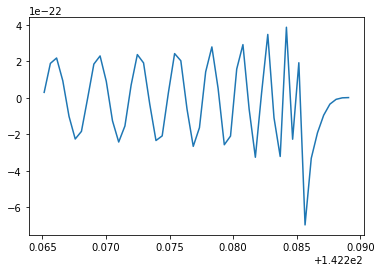

In [4]:
plt.plot(gw[0, -50:], gw[1, -50:]);

In [5]:
def prepare_gw(sig, sr=2048, error_ms=5):
    
    if len(sig) < 4096:
        pad = 4096 - len(sig)
        sig = np.pad(sig, (0, pad))
    
    # Time lags https://arxiv.org/abs/1706.04191
    # https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/251934#1387136
    
    # Start the GW from Hanford
    if np.random.rand() > 0.5:
        hanford_delay = 0 + np.random.normal(scale=error_ms)
        livingston_delay = 10 + np.random.normal(scale=error_ms)
        virgo_delay = 26 + np.random.normal(scale=error_ms)
    # Start the GW from Virgo
    else:
        hanford_delay = 27 + np.random.normal(scale=error_ms)
        livingston_delay = 26 + np.random.normal(scale=error_ms)
        virgo_delay = 0 + np.random.normal(scale=error_ms)
    
    
    random_pad = np.random.randint(30, int(4096 * 0.85))
    
    hanford_pad = int(sr * hanford_delay / 1000) + random_pad
    livingston_pad = int(sr * livingston_delay / 1000) + random_pad
    virgo_pad = int(sr * virgo_delay / 1000) + random_pad
    
    hanford_sig = np.pad(sig, (0, hanford_pad))[-4096:]
    livingston_sig = np.pad(sig, (0, livingston_pad))[-4096:]    
    virgo_sig = np.pad(sig, (0, virgo_pad))[-4096:]
    return np.stack([hanford_sig, livingston_sig, virgo_sig])

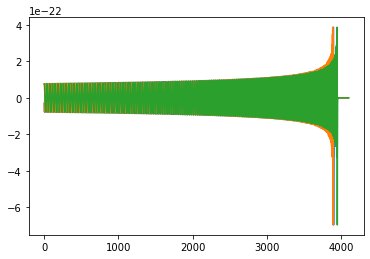

In [6]:
gw_test = prepare_gw(gw[1])
plt.plot(gw_test.T);

In [7]:
def apply_bandpass(x, lf=25, hf=1000, order=4, sr=2048):
    #     sos = signal.butter(order, [lf * 2.0 / sr, hf * 2.0 / sr], btype="bandpass", output="sos")
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization


def make_spec(sig, hop_length=64, sr=2048):
    sig = apply_bandpass(sig)
    d1 = sig * signal.tukey(len(sig), 0.2)
#     d1 = sig
    C = np.abs(
        librosa.cqt(
            d1 / np.max(d1),
            sr=sr,
            hop_length=hop_length,
            fmin=8,
            filter_scale=0.8,
            bins_per_octave=12,
        )
    )
    print(C.min(), C.max())
    fig, ax = plt.subplots(figsize=(10, 10))
    img = librosa.display.specshow(
        C, sr=sr * 2, hop_length=hop_length, bins_per_octave=12, ax=ax
    )
    ax.set_title("Constant-Q power spectrum")

4.213249270258457e-09 6.238576503432319


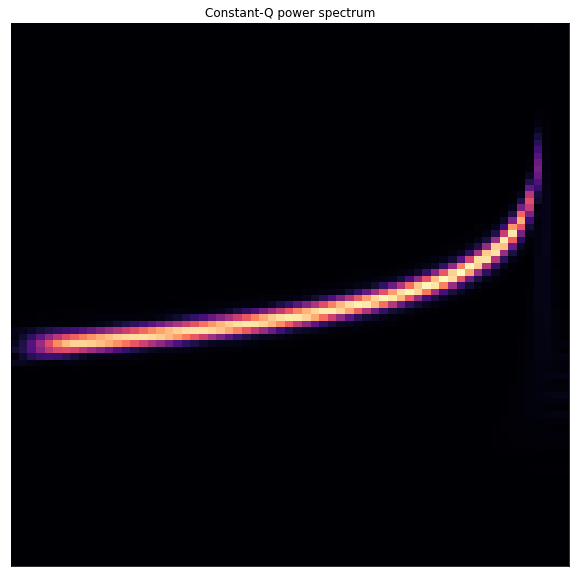

In [8]:
make_spec(gw_test[2])

# Combine with noise

In [9]:
df = pd.read_csv(INPUT_PATH / "training_labels.csv").query("target == 0")
print(df.shape)
df.head(10)

(280070, 2)


,id,target
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
6,0000c3b9c9,0
10,000118b40d,0
13,0001616241,0
16,0001bfda2f,0
18,0002014fd3,0
19,0002402e11,0
20,000243542d,0


In [10]:
def load_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
#     return waves / np.max(np.abs(waves), axis=1).reshape(3, 1)
    return waves # / np.max(np.abs(waves))

In [11]:
noise = load_file("00001f4945")
gw_synthetic = prepare_gw(gw[1])

synthetic = 0.5 * gw_synthetic + noise

In [12]:
# make_spec(noise[0])

2.40710447365329e-05 2.0012796647323974


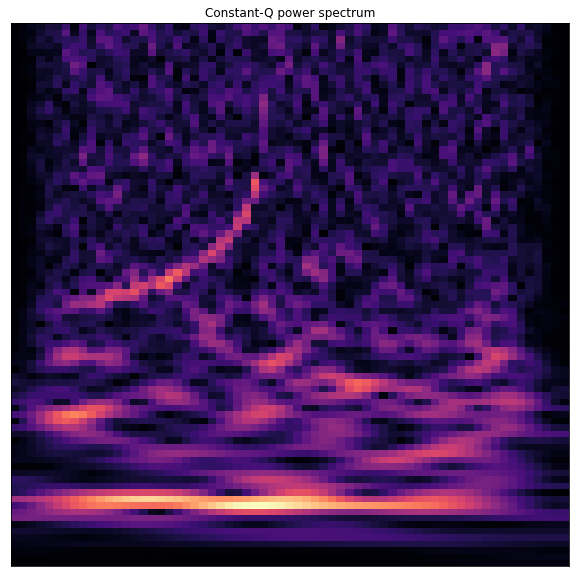

In [13]:
make_spec(synthetic[0])

# PyTorch dataset

In [25]:
class GWSyntheticDataset(Dataset):
    def __init__(
        self,
        df,
        tukey_alpha=0.2,
        bp_lf=25,
        bp_hf=500,
        bp_order=4,
        whiten=False,
        folder="train",
        channel_shuffle=False,
        **kwargs,
    ):
        self.df = df.query("target == 0").reset_index(drop=True)
        self.folder = folder
        self.window = torch.tensor(signal.tukey(4096, tukey_alpha))
        self.lf = bp_lf
        self.hf = bp_hf
        self.order = bp_order
        self.gw_paths = list((INPUT_PATH / "gw_sim").glob("*.npy"))

    def load_file(self, id_):
        path = INPUT_PATH / self.folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
        waves = np.load(path)
        return waves

    def prepare_gw(self, sig, sr=2048, error_ms=5):
        if len(sig) < 4096:
            pad = 4096 - len(sig)
            sig = np.pad(sig, (0, pad))
        
        # Time lags https://arxiv.org/abs/1706.04191
        # https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/251934#1387136

        # Start the GW from Hanford
        if np.random.rand() > 0.5:
            hanford_delay = 0 + np.random.normal(scale=error_ms)
            livingston_delay = 10 + np.random.normal(scale=error_ms)
            virgo_delay = 26 + np.random.normal(scale=error_ms)
        # Start the GW from Virgo
        else:
            hanford_delay = 27 + np.random.normal(scale=error_ms)
            livingston_delay = 26 + np.random.normal(scale=error_ms)
            virgo_delay = 0 + np.random.normal(scale=error_ms)

        random_pad = np.random.randint(30, int(4096 * 0.85))

        hanford_pad = int(sr * hanford_delay / 1000) + random_pad
        livingston_pad = int(sr * livingston_delay / 1000) + random_pad
        virgo_pad = int(sr * virgo_delay / 1000) + random_pad

        hanford_sig = np.pad(sig, (0, hanford_pad))[-4096:]
        livingston_sig = np.pad(sig, (0, livingston_pad))[-4096:]
        virgo_sig = np.pad(sig, (0, virgo_pad))[-4096:]
        return np.stack([hanford_sig, livingston_sig, virgo_sig])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.load_file(self.df.loc[index, "id"])
        data = torch.tensor(data, dtype=torch.float32)
        scale = torch.abs(data).max()

        if np.random.rand() > 0.5:
            target = torch.tensor([1], dtype=torch.float32)
            gw = np.load(np.random.choice(self.gw_paths))[1]
            data_clean = torch.tensor(self.prepare_gw(gw), dtype=torch.float32)
            amplitude = np.random.uniform(low=0.1, high=0.5)
            print(amplitude)
            data_clean *= amplitude  # Random amplitude
            data += data_clean
            data_clean /= scale

        else:
            target = torch.tensor([0], dtype=torch.float32)
            data_clean = torch.normal(mean=0, std=1e-10, size=data.shape)

        data /= scale

        data *= self.window
#         data = biquad_bandpass_filter(data, self.lf, self.hf, 2048)

        return data, data_clean, target

In [26]:
ds = GWSyntheticDataset(df)

0.4633535213682408
tensor([1.])
9.972418397620324e-08 1.74566348265665
3.693846243213303e-32 1.7531314206297333


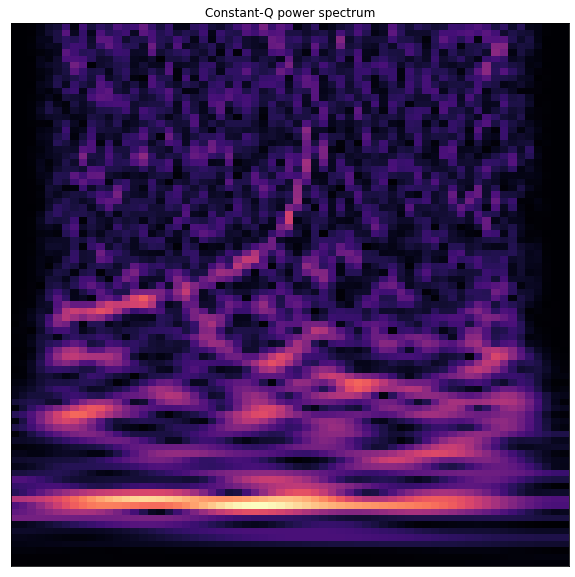

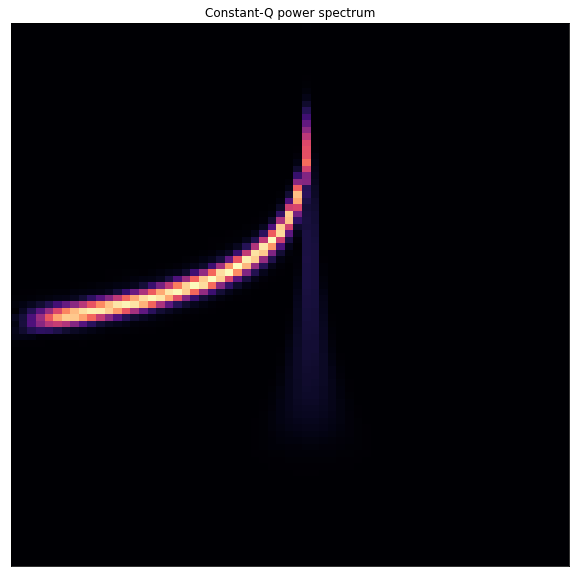

In [47]:
x = ds[0]
print(x[2])

make_spec(x[0][0].numpy())

if x[2] > 0:
    make_spec(x[1][0].numpy())

In [40]:
a = torch.randn(size=(4, 3, 2, 2))
target = torch.tensor([1, 0, 1, 0], dtype=torch.float).view(-1, 1)
a[~target.flatten().bool()] = 0

In [41]:
a

tensor([[[[-0.5363, -1.9584],
          [-1.4114, -1.3461]],

         [[ 0.1269, -0.1338],
          [ 0.9970,  1.0413]],

         [[ 0.2943, -0.6344],
          [ 0.5379, -0.7452]]],


        [[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]],


        [[[ 0.2281, -0.7768],
          [ 1.4715,  0.8447]],

         [[-0.0321,  0.9790],
          [ 0.3696,  0.7286]],

         [[-0.8135, -0.9643],
          [ 0.3711,  0.3787]]],


        [[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]]])